In [460]:
import numpy as np
import pylab as pl
import arrayfire as af
af.set_backend("cpu")
%matplotlib inline

In [461]:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'  

In [462]:
# Setting velocity and spatial grid points
N_positions = 101
ghost_zones = 3
N_velocity  = 101

In [463]:
# Boundaries of domain
left_boundary  = 0
right_boundary = 1.0
length         = right_boundary - left_boundary

In [464]:
# Setting mass of the particle, boltzmann-constant
mass_particle      = 1.0
boltzmann_constant = 1.0

In [465]:
# Scattering time scale
tau   = 1
# Magnitude of maximum velocity
v_max = 10.0

In [466]:
# Time Parameters for the simulation:
dt         = 0.05 # Size of the time-step
final_time = 2.0
time       = np.arange(dt, final_time, dt)

In [467]:
# Setting up the temperature parameters for the simulations:
T_left   = 1.0
T_right  = 1.1
T_initial = 1.0

In [468]:
# Setting up of spatial and velocity grids:
x  = np.linspace(left_boundary, right_boundary, N_positions)
dx = x[1] - x[0]

In [469]:
# Obtaining the coordinates for the ghost-zones:
x_ghost_left  = np.linspace(-(ghost_zones)*dx + left_boundary, left_boundary - dx, ghost_zones)
x_ghost_right = np.linspace(right_boundary + dx, right_boundary + ghost_zones*dx , ghost_zones)

In [470]:
# Combining them to obtain the entire spatial grid
x  = np.concatenate([x_ghost_left, x, x_ghost_right])

In [471]:
# Obtaining the velocity grid
v  = np.linspace(-v_max, v_max, N_velocity)
x  = af.to_array(x)
v  = af.to_array(v)

In [472]:
# Conversion to allow for easy vectorization
x = af.tile(x, 1, N_velocity)
v = af.tile(af.reorder(v), N_positions + 2*ghost_zones, 1)

In [473]:
def calculate_density(f, v):
    deltav           = af.sum(v[0, 1]-v[0, 0])
    value_of_density = af.sum(f, 1)*deltav
    return(value_of_density)

In [474]:
def calculate_temperature(f, v):
    deltav               = af.sum(v[0, 1]-v[0, 0])
    value_of_temperature = af.sum(f*v**2, 1)*deltav
    return(value_of_temperature)

In [475]:
def calculate_heatflux(f, v):
    deltav               = af.sum(v[0, 1]-v[0, 0])
    value_of_heatflux    = af.sum(f*v**3, 1)*deltav
    return(value_of_heatflux)

In [476]:
def f_MB(x, v, f):
    n = af.tile(calculate_density(f, v), 1, N_velocity)
    T = af.tile(calculate_temperature(f, v), 1, N_velocity)
    f_MB = n*af.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T))*\
             af.exp(-mass_particle*v**2/(2*boltzmann_constant*T))
    return(f_MB)


In [477]:
def f_interp(dt, x, v, f):
    x_new     = x - v*dt
    step_size = af.sum(x[1,0] - x[0,0])
    f_inter   = af.constant(0, N_positions + 2*ghost_zones, N_velocity)
    f_inter[ghost_zones:-ghost_zones,:] = af.approx1(f, (x_new[ghost_zones:-ghost_zones,:]/step_size), af.INTERP.CUBIC)
    
    f_inter   = af.Array.as_type(f_inter, af.Dtype.f64)
    
    f_left    = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_left))*\
                af.exp(-mass_particle*v**2/(2*boltzmann_constant*T_left))
    
    f_right   = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_right))*\
                af.exp(-mass_particle*v**2/(2*boltzmann_constant*T_right))
    
    f_inter[ghost_zones:-ghost_zones,:] = af.select(x_new[ghost_zones:-ghost_zones, :]<=left_boundary, \
                                                     f_left[ghost_zones:-ghost_zones,:], \
                                                     f_inter[ghost_zones:-ghost_zones,:]
                                                    )
    
    f_inter[ghost_zones:-ghost_zones,:] = af.select(x_new[ghost_zones:-ghost_zones, :]>=right_boundary, \
                                                     f_right[ghost_zones:-ghost_zones,:], \
                                                     f_inter[ghost_zones:-ghost_zones,:]
                                                    )
    
    return f_inter


In [478]:
# Intializing the values for f
f_initial = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_initial)) * \
            af.exp(-mass_particle*v**2/(2*boltzmann_constant*T_initial))

In [479]:
f_initial[:ghost_zones,:] = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_left)) * \
                            af.exp(-mass_particle*v[:ghost_zones, :]**2/(2*boltzmann_constant*T_left))
    
f_initial[N_positions + ghost_zones:N_positions + 2 * ghost_zones, :] = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_right)) * \
                                                                        af.exp(-mass_particle*v[:ghost_zones, :]**2/(2*boltzmann_constant*T_right))

In [480]:
f_current = f_initial
sol2 = np.zeros(time.size)

In [481]:
for time_index, t0 in enumerate(time):
    #print("Computing For Time Index = ", time_index)
    #print("Physical Time            = ", t0)
    # We shall split the Boltzmann-Equation and solve it:
    # In this step we are solving the collisionless equation
    fstar = f_interp(dt, x, v, f_current)
    
    fstar[:ghost_zones,:] = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_left)) * \
                            af.exp(-mass_particle*v[:ghost_zones, :]**2/(2*boltzmann_constant*T_left))
    
    fstar[N_positions + ghost_zones:N_positions + 2 * ghost_zones, :] = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_right)) * \
                                                                        af.exp(-mass_particle*v[:ghost_zones, :]**2/(2*boltzmann_constant*T_right))

    # We turn off the term v(df/dx) for the following two steps
    f0             = f_MB(x, v, fstar)
    f_new          = f0 + (fstar - f0)*np.exp(-dt/tau)
    
    f_new[:ghost_zones,:] = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_left)) * \
                            af.exp(-mass_particle*v[:ghost_zones, :]**2/(2*boltzmann_constant*T_left))
    
    f_new[N_positions + ghost_zones:N_positions + 2 * ghost_zones, :] = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_right)) * \
                                                                        af.exp(-mass_particle*v[:ghost_zones, :]**2/(2*boltzmann_constant*T_right))


    f_current = f_new
    #f_current = fstar
    temp      = calculate_temperature(f_current[ghost_zones:-ghost_zones, :], v[ghost_zones:-ghost_zones, :])
    sol2[time_index] = af.sum(temp)/af.Array.elements(temp)

[ 1.00662744  1.01116999  1.01570324  1.02018943  1.02463282  1.02897351
  1.03305897  1.03672645  1.03986503  1.0424739   1.0446138   1.04633766
  1.04765579  1.04876921  1.04957057  1.05027046  1.05075692  1.05114985
  1.05148358  1.05171831  1.05188483  1.05202136  1.05213263  1.05222291
  1.05227229  1.05230206  1.05232237  1.05233481  1.05234083  1.05234151
  1.05233779  1.05233061  1.05231651  1.05229879  1.05228015  1.05226093
  1.05224131  1.05222146  1.05220163]


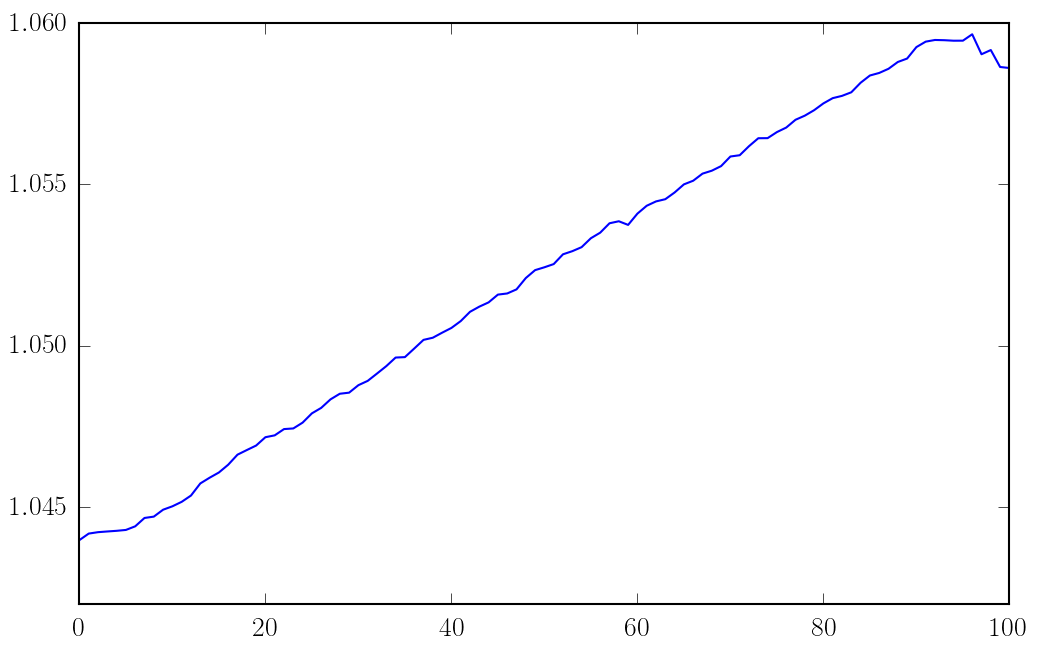

In [482]:
#flux = calculate_heatflux(f_current, v)
#avg  = af.sum(flux[3:-3])/(N_positions)
#print(avg)
pl.plot(temp)
print(sol2)

In [483]:
# deltaT = 0.1*np.arange(1, 11)
# q_x = np.array([-0.0989624012124193,\
# -0.20331882890922767,\
# -0.31284980228686665,\
# -0.42736068843081526,\
# -0.5466773486686046,\
# -0.6706427765659095,\
# -0.7991144589476223,\
# -0.9319622727811506,\
# -1.069066789400572,\
# -1.2103178806008192 \
# ])

In [484]:
# deltaT = 0.01*np.arange(1, 11)
# q_x = np.array([-1.80904584449086e-05,\
# -3.6349960261074263e-05,\
# -5.4778314018725176e-05,\
# -7.337533157176087e-05,\
# -9.214083556117072e-05,\
# -0.00011107464789662132,\
# -0.00013017658633379813,\
# -0.0001494464766615207,\
# -0.00016888414457364947,\
# -0.00018848941731804087\
# ])

In [485]:
# pl.plot(deltaT, q_x)
# pl.xlabel('$\Delta$T')
# pl.ylabel('$q$')
# pl.title('$\mathrm{HeatFlux}$ $\mathrm{vs}$ $\Delta$T')